In [1]:
import torch
import torch.nn as nn
import torch.optim as optim


class ComplexReLU(nn.Module):
    def __init__(self):
        super(ComplexReLU, self).__init__()
        self.relu = nn.ReLU()

    def forward(self, x):
        real = self.relu(x.real)
        imag = self.relu(x.imag)
        return torch.complex(real, imag)

In [2]:
from argparse import Namespace
import torch
from torch import nn
from torch.fft import rfft

# An implementation of the FITS model as described in https://arxiv.org/abs/2307.03756 (FITS: Frequency Interpolation Time Series Forecasting)
# with better annotation and more clear model structure - the original code for the model can be found here: https://github.com/VEWOXIC/FITS


class FITS(nn.Module):
    """Reimplementation of the FITS model.

    This model contains an annotated and more cleany written model, which is true to the model described in the paper* and the original code.
    *(RIN was not performed in the code, but instance wise normalization was performed instead).
    """

    def __init__(
        self,
        args: Namespace,
    ):
        super(FITS, self).__init__()

        self.cutoff_frequency = args.dominance_freq
        self.seq_len = args.seq_len
        self.pred_len = args.pred_len
        self.upsample_rate = (args.seq_len + args.pred_len) / args.seq_len
        self.channels = args.channels
        self.num_layers = args.num_layers

        layers = []
        in_features = args.dominance_freq
        for i in range(self.num_layers):
            out_features = (
                int(args.dominance_freq * self.upsample_rate)
                if self.num_layers == 1 or i == self.num_layers - 1
                else args.num_hidden
            )
            layers.append(
                nn.Linear(
                    in_features=in_features,
                    out_features=out_features,
                    dtype=torch.cfloat,
                    bias=True,
                )
            )
            if i != self.num_layers - 1:
                layers.append(ComplexReLU())
            in_features = out_features

        self.frequency_upsampler = (
            nn.Sequential(*layers)
            if not args.individual
            else nn.ModuleList([nn.Sequential(*layers) for _ in range(args.channels)])
        )

        self.individual = args.individual
        self.debug = args.debug
        if args.debug:
            self.debug_tensors = {}

    def channel_wise_frequency_upsampler(
        self, ts_frequency_data_filtered: torch.Tensor
    ) -> torch.Tensor:
        """Performs the complex valued layer frequency upsampling on a per-channel basis."""
        complex_valued_data = torch.zeros(
            [
                ts_frequency_data_filtered.size(0),
                int(self.cutoff_frequency * self.upsample_rate),
                ts_frequency_data_filtered.size(2),
            ],
            dtype=ts_frequency_data_filtered.dtype,
        ).to(ts_frequency_data_filtered.device)
        for i in range(self.channels):
            complex_valued_data[:, :, i] = self.frequency_upsampler[i](
                ts_frequency_data_filtered[:, :, i]
            )
        return complex_valued_data

    def forward(self, ts_data: torch.Tensor) -> torch.Tensor:
        # 1) Normalization of the input tensor:
        ts_mean, ts_var = (
            torch.mean(ts_data, dim=1, keepdim=True),
            torch.var(ts_data, dim=1, keepdim=True) + 1e-5,
        )
        normalized_ts_data = (ts_data - ts_mean) / torch.sqrt(ts_var)

        # 2) perform real fast fourier transform on the input tensor
        ts_frequency_data = rfft(input=normalized_ts_data, dim=1)

        # 3) perform a low pass filter to remove high frequency noise, which contributes little to the overall signal
        ts_frequency_data_filtered = ts_frequency_data[:, 0 : self.cutoff_frequency, :]

        # 4) Run the tensor through a complex valued linear layer
        if self.individual:
            complex_valued_data = self.channel_wise_frequency_upsampler(
                ts_frequency_data_filtered
            )
        else:
            complex_valued_data = self.frequency_upsampler(
                ts_frequency_data_filtered.permute(0, 2, 1)
            ).permute(0, 2, 1)

        # 5) obtain new frequencies from the output of the complex valued linear layer
        norm_spec_xy = torch.zeros(
            [
                complex_valued_data.size(0),
                int((self.seq_len + self.pred_len) / 2 + 1),
                complex_valued_data.size(2),
            ],
            dtype=complex_valued_data.dtype,
        ).to(complex_valued_data.device)

        # 6) 0 pad the output tensor
        norm_spec_xy[:, 0 : complex_valued_data.size(1), :] = complex_valued_data

        # 7) perform inverse real fast fourier transform on the output tensor
        norm_xy = torch.fft.irfft(norm_spec_xy, dim=1)
        norm_xy = norm_xy * self.upsample_rate

        # 8) Reverse Normalization
        xy = norm_xy * torch.sqrt(ts_var) + ts_mean

        if self.debug:
            self.debug_tensors = {
                "normalized_ts_data": normalized_ts_data,
                "ts_frequency_data": ts_frequency_data,
                "ts_frequency_data_filtered": ts_frequency_data_filtered,
                "complex_valued_data": complex_valued_data,
                "norm_spec_xy": norm_spec_xy,
                "norm_xy": norm_xy,
                "xy": xy,
            }

        return xy

In [4]:
from synthgen import SyntheticDatasetGenerator
import numpy as np

seq_len = 720
pred_len = 720
batch_size = 32
n_features = 1
n_samples = 10000

ds = SyntheticDatasetGenerator(length=n_samples, num_channels=1)
# ds.add_linear_trend(slope=-50 / n_samples, intercept=0)
ds.add_sin_wave(amplitude=0.3, frequency=200)
ds.add_sin_wave(amplitude=0.3, frequency=500)
ds.add_noise(mean=0, std=0.3)
ds.add_exponential_growth(1 + (3 / n_samples))
ds.add_random_signal_with_precursor(
    precursor_amplitude=2,
    signal_amplitude=4,
    max_precursor_length=200,
    min_delay=150,
    max_delay=200,
    num_signals=int(n_samples / 500),
)

y = ds.data

# normalize
y_mean = np.mean(y, axis=0)
y_std = np.std(y, axis=0)
y = (y - y_mean) / y_std

In [6]:
criterion = nn.MSELoss()


def train(n_epochs, model, model_optim, finetune=False):
    for epoch in range(n_epochs):
        order = np.random.permutation(n_samples // 2)
        train_loss = []
        for batch in range(25):
            batch_start = order[batch * batch_size : (batch + 1) * batch_size]
            batch = []
            for i in batch_start:
                batch.append(y[i : i + seq_len + pred_len])
            batch_xy = np.array(batch).reshape(
                batch_size, seq_len + pred_len, n_features
            )

            batch_xy = torch.from_numpy(batch_xy).float()

            batch_x = batch_xy[:, :seq_len, :]
            batch_y = batch_xy[:, seq_len:, :]

            model_optim.zero_grad()

            output = model(batch_x)
            if finetune:
                loss = criterion(output[:, seq_len:], batch_y)
            else:
                loss = criterion(output, batch_xy)

            train_loss.append(loss.item())

            loss.backward()

            model_optim.step()

        print(f"\repoch: {epoch} loss: {np.mean(train_loss):1f}", flush=True, end="")
    # print(np.mean(train_loss))
    return model, output.cpu().detach().numpy(), batch_xy.cpu().detach().numpy()

In [7]:
conf = Namespace(
    dominance_freq=100,
    seq_len=seq_len,
    pred_len=pred_len,
    channels=1,
    individual=False,
    debug=False,
    num_layers=1,
    num_hidden=64,
)

model = FITS(conf)

model_optim = optim.Adam(model.parameters(), lr=1e-4)

print(sum(p.numel() for p in model.parameters()))
print(model)

model, out, batch = train(1000, model, model_optim)

20200
FITS(
  (frequency_upsampler): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
  )
)
epoch: 999 loss: 0.075483

In [10]:
conf = Namespace(
    dominance_freq=100,
    seq_len=seq_len,
    pred_len=pred_len,
    channels=1,
    individual=False,
    debug=False,
    num_layers=5,
    num_hidden=64,
)

model = FITS(conf)

model_optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

print(sum(p.numel() for p in model.parameters()))

print(model)

model, out, batch = train(1000, model, model_optim)

31944
FITS(
  (frequency_upsampler): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ComplexReLU(
      (relu): ReLU()
    )
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ComplexReLU(
      (relu): ReLU()
    )
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ComplexReLU(
      (relu): ReLU()
    )
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ComplexReLU(
      (relu): ReLU()
    )
    (8): Linear(in_features=64, out_features=200, bias=True)
  )
)
epoch: 999 loss: 0.011117

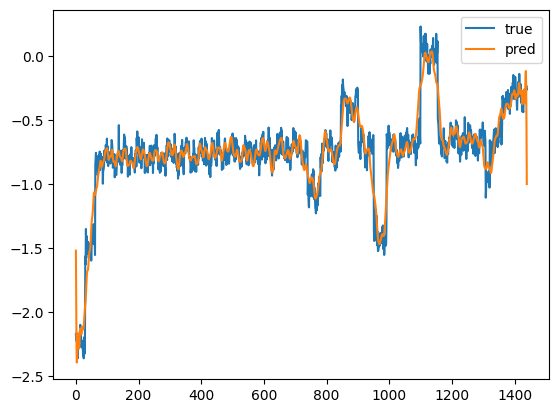

In [69]:
from matplotlib import pyplot as plt

plt.plot(batch[0, :, 0], label="true")
plt.plot(out[0, :, 0], label="pred")
plt.legend()

# ETTh1

In [47]:
import pandas as pd

df = pd.read_csv("ETT-small/ETTh1.csv")
df.drop(columns=["date"], inplace=True)

data = df.to_numpy()
# normalize channel-wise
data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
data = (data - data_mean) / data_std

In [48]:
train_data = data[:13000]
test_data = data[13000:]

valid_start_index = [0, 13000 - seq_len - pred_len]
valid_end_index = [seq_len + pred_len, 13000]

In [52]:
from torch.utils.data import Dataset, DataLoader


class ETTH1Dataset(Dataset):
    def __init__(self, data, seq_len, pred_len):
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.seq_len]
        y = self.data[idx + self.seq_len : idx + self.seq_len + self.pred_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(
            y, dtype=torch.float32
        )


# Create datasets
train_dataset = ETTH1Dataset(train_data, seq_len, pred_len)
test_dataset = ETTH1Dataset(test_data, seq_len, pred_len)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

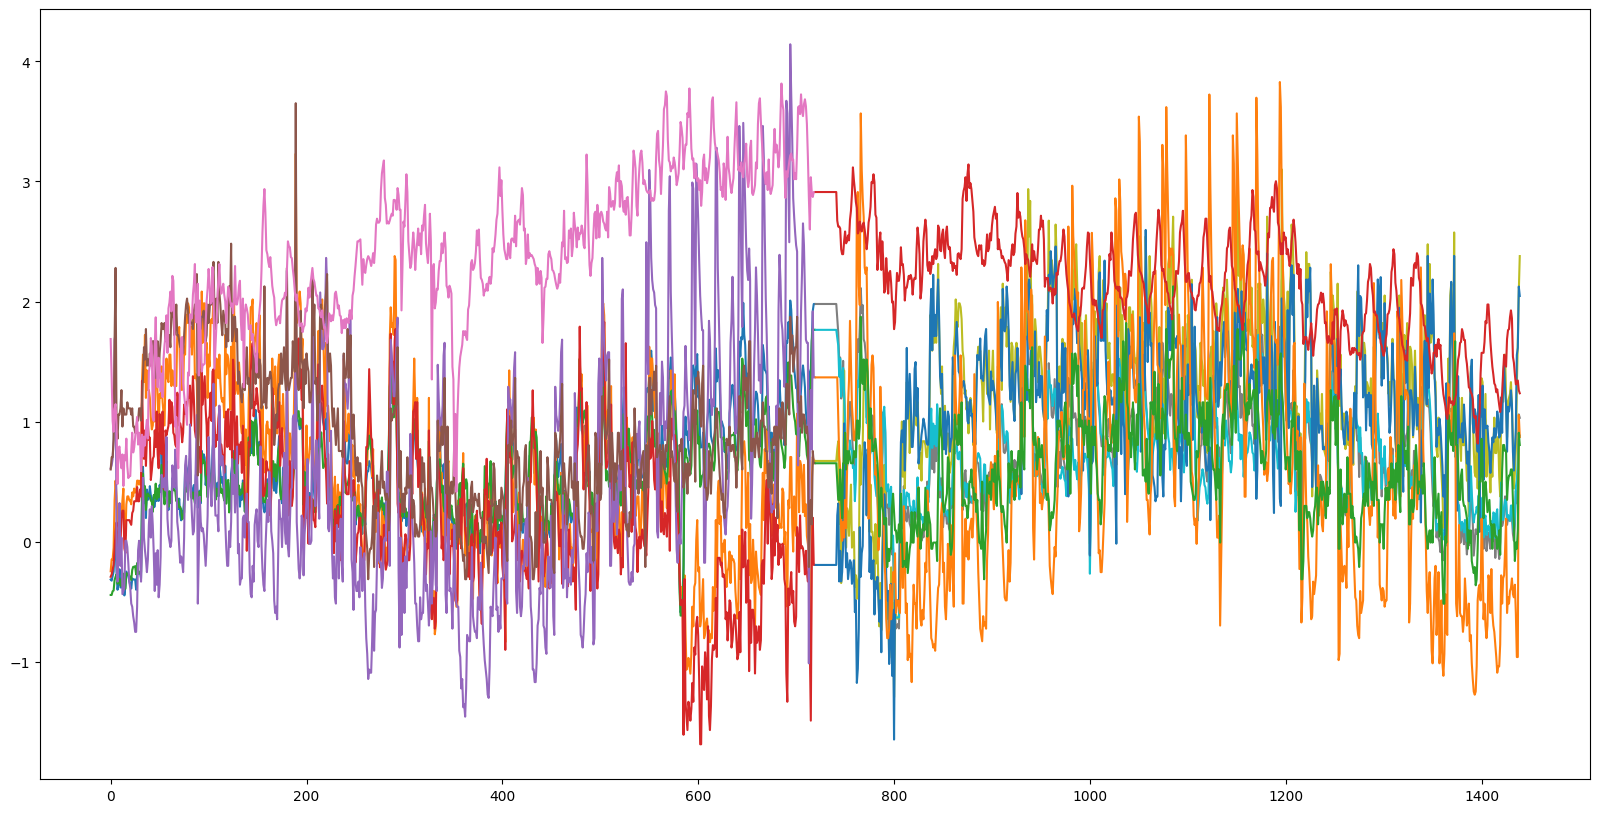

In [68]:
plt.figure(figsize=(20, 10))
plt.plot(train_dataset[2][0])
# y after seq_len
plt.plot(range(seq_len, seq_len + pred_len), train_dataset[2][1])
plt.show()

In [53]:
num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = (
            x.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")),
            y.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")),
        )
        optimizer.zero_grad()
        output = model(x)
        xy = torch.cat((x, y), dim=1)
        loss = criterion(output[:, seq_len:], y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = (
                x.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")),
                y.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")),
            )
            output = model(x)
            loss = criterion(output[:, seq_len:], y)
            val_loss += loss.item() * x.size(0)

    val_loss /= len(test_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

Epoch 1/10, Training Loss: 0.5257
Epoch 1/10, Validation Loss: 0.7194
Epoch 2/10, Training Loss: 0.5210
Epoch 2/10, Validation Loss: 0.7198
Epoch 3/10, Training Loss: 0.5172
Epoch 3/10, Validation Loss: 0.7400
Epoch 4/10, Training Loss: 0.5133
Epoch 4/10, Validation Loss: 0.7308
Epoch 5/10, Training Loss: 0.5094
Epoch 5/10, Validation Loss: 0.7272


KeyboardInterrupt: 